# COVID-19 Data Analysis
**Joe Corliss**

Data download links

* Confirmed cases: [time_series_covid19_confirmed_global.csv](https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv)
* Deaths: [time_series_covid19_deaths_global.csv](https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv)
* Recovered: [time_series_covid19_recovered_global.csv](https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv)

## Execution Options

In [1]:
# Config
DATA_PATH = '../data/'

# Modeling
metric = 'confirmed'  # Variable of interest
log_metric = True  # Take log of the metric?
days_history = 10  # Number of consecutive past days to use for prediction (including the current day)
days_horizon = 7  # Number of days ahead to predict
metric_min = {'confirmed': 100, 'deaths': 10}  # Filter out samples where the metric is below this value

In [2]:
# Validate input
assert isinstance(DATA_PATH, str), "Bad input for option 'DATA_PATH'"
assert metric in {'confirmed', 'deaths'}, "Bad input for option 'metric'"
assert isinstance(log_metric, bool), "Bad input for option 'log_metric'"
assert isinstance(days_history, int) and days_history >= 1, "Bad input for option 'days_history'"
assert isinstance(days_horizon, int) and days_horizon >= 1, "Bad input for option 'days_horizon'"
assert isinstance(metric_min, dict), "Bad input for option 'metric_min'"

## Imports

In [3]:
import datetime
import sys

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
# Check package versions
assert sys.version.split()[0] == '3.6.10', 'Unexpected Python version: expected 3.6.10, got {}'.format(sys.version.split()[0])
assert mpl.__version__ == '3.1.3', 'Unexpected matplotlib version: expected 3.1.3, got {}'.format(mpl.__version__)
assert np.__version__ == '1.18.1', 'Unexpected numpy version: expected 1.18.1, got {}'.format(np.__version__)
assert pd.__version__ == '1.0.3', 'Unexpected pandas version: expected 1.0.3, got {}'.format(pd.__version__)

In [6]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

## Functions

In [7]:
def compare_locales(df1, df2):
    """Check whether two time series DataFrames have the same State/Country indices."""
    if df1.shape != df2.shape:
        return False
    else:
        comparison = (df1.iloc[:, :2] == df2.iloc[:, :2]) | (df1.iloc[:, :2].isna() & df2.iloc[:, :2].isna())
        return comparison.all().all()

## Load data

In [8]:
confirmed = pd.read_csv(DATA_PATH + 'time_series_covid19_confirmed_global.txt')
deaths = pd.read_csv(DATA_PATH + 'time_series_covid19_deaths_global.txt')
# recovered = pd.read_csv(DATA_PATH + 'time_series_covid19_recovered_global.txt')

In [9]:
print('Confirmed updated to:\t', confirmed.columns[-1])
print('Deaths updated to:\t', deaths.columns[-1])

Confirmed updated to:	 3/29/20
Deaths updated to:	 3/29/20


In [10]:
assert compare_locales(confirmed, deaths), 'confirmed and deaths DataFrames have different locales'

In [11]:
values = eval(metric)

In [12]:
values.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 72 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  79 non-null     object 
 1   Country/Region  253 non-null    object 
 2   Lat             253 non-null    float64
 3   Long            253 non-null    float64
 4   1/22/20         253 non-null    int64  
 5   1/23/20         253 non-null    int64  
 6   1/24/20         253 non-null    int64  
 7   1/25/20         253 non-null    int64  
 8   1/26/20         253 non-null    int64  
 9   1/27/20         253 non-null    int64  
 10  1/28/20         253 non-null    int64  
 11  1/29/20         253 non-null    int64  
 12  1/30/20         253 non-null    int64  
 13  1/31/20         253 non-null    int64  
 14  2/1/20          253 non-null    int64  
 15  2/2/20          253 non-null    int64  
 16  2/3/20          253 non-null    int64  
 17  2/4/20          253 non-null    int

Check missing values:

In [13]:
assert (~values.isnull().any()[1:]).all(), 'Unexpected missing data!'

In [14]:
values.drop(columns={'Lat', 'Long'}, inplace=True)

In [15]:
values.rename(columns={'Country/Region': 'country', 'Province/State': 'province'}, inplace=True)

## Look at Countries Split Up by Province/State

Which countries have their time series broken up into regions or provinces?

In [16]:
country_counts = values['country'].value_counts()
print(country_counts[country_counts > 1])

China             33
Canada            15
United Kingdom    10
France            10
Australia          8
Netherlands        4
Denmark            3
Name: country, dtype: int64


List current value by country and province, sorted by country ascending, then value descending:

In [17]:
values.loc[values['country'].map(country_counts > 1)].iloc[:, [1, 0, -1]].sort_values(['country', values.columns[-1]], ascending=[True, False])

,country,province,3/29/20
9,Australia,New South Wales,1791
14,Australia,Victoria,769
11,Australia,Queensland,656
15,Australia,Western Australia,311
12,Australia,South Australia,299
8,Australia,Australian Capital Territory,77
13,Australia,Tasmania,66
10,Australia,Northern Territory,15
44,Canada,Quebec,2840
42,Canada,Ontario,1355


## Processing

In [18]:
values.insert(0, 'locale', values['country'].where(values['province'].isnull(), values['country'] + '/' + values['province']))

In [19]:
values.drop(columns={'province', 'country'}, inplace=True)

In [51]:
idx = 0

Plot values for each locale (repeat this cell) - Skip locales with fewer than 100 cases today:

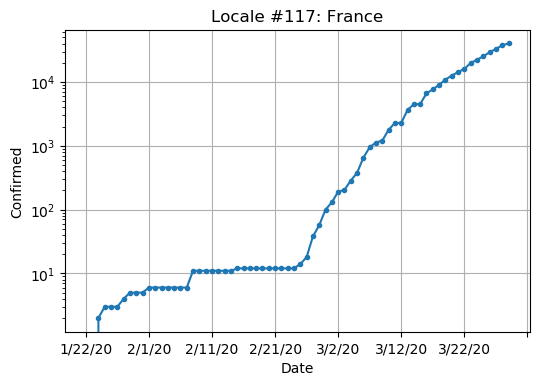

In [68]:
if idx < values.shape[0]:
    while values.iloc[idx, -1] < 1000:
        idx += 1
    plt.figure(dpi=100)
    values.iloc[idx, 1:].plot.line(marker='.', logy=log_metric)
    plt.grid(True)
    plt.title('Locale #{idx}: {locale}'.format(idx=idx + 1, locale=values.iloc[idx, 0]))
    plt.xlabel('Date')
    plt.ylabel(metric.capitalize())
    idx += 1

In [22]:
values_melt = values.melt(id_vars=['locale'], var_name='date', value_name='value')

In [23]:
values_melt['date'] = pd.to_datetime(values_melt['date'])

In [24]:
values_melt = values_melt.loc[values_melt['value'] >= metric_min[metric]]

In [25]:
if log_metric:
    values_melt['value'] = values_melt['value'].map(np.log10)

## Construct Final Datasets

In [26]:
X_schema = pd.DataFrame(columns=['locale', 'date'] + ['value_d{}'.format(-idx) for idx in range(days_history - 1, -1, -1)])

In [27]:
y_schema = pd.DataFrame(columns=['locale', 'date'] + ['value_d+{}'.format(days_horizon)])

In [28]:
X_train = X_schema.copy()
y_train = y_schema.copy()

In [29]:
X_pred = X_schema.copy()

In [30]:
for locale in values_melt['locale'].unique():
    values_melt_locale = values_melt.loc[values_melt['locale'] == locale].sort_values('date')
    
    # Add to training data
    idx = 0
    while idx + (days_history - 1) + days_horizon <= values_melt_locale.shape[0] - 1:
        locale_date_to_append = values_melt_locale.iloc[idx + (days_history - 1), :2].to_dict()
        
        X_train_to_append = dict(zip(X_train.columns[2:], values_melt_locale['value'].iloc[idx : idx + days_history]))
        X_train_to_append.update(locale_date_to_append)
        X_train = X_train.append(X_train_to_append, ignore_index=True)
        
        y_train_to_append = {y_train.columns[-1]: values_melt_locale['value'].iloc[idx + (days_history - 1) + days_horizon]}
        y_train_to_append.update(locale_date_to_append)
        y_train = y_train.append(y_train_to_append, ignore_index=True)
        
        idx += 1
        
    # Add to prediction data
    if days_history <= values_melt_locale.shape[0]:  # Can only predict if we have enough days of history
        locale_date_to_append = values_melt_locale.iloc[-1, :2].to_dict()
        X_pred_to_append = dict(zip(X_pred.columns[2:], values_melt_locale['value'].iloc[-days_history:]))
        X_pred_to_append.update(locale_date_to_append)
        X_pred = X_pred.append(X_pred_to_append, ignore_index=True)

In [31]:
X_train.set_index(['locale', 'date'], inplace=True, verify_integrity=True)
y_train.set_index(['locale', 'date'], inplace=True, verify_integrity=True)
X_pred.set_index(['locale', 'date'], inplace=True, verify_integrity=True)

In [32]:
X_train.shape

(1310, 10)

In [33]:
y_train.shape

(1310, 1)

In [34]:
X_pred.shape

(96, 10)

In [35]:
X_train.tail(100)

value_d-9  value_d-8  value_d-7  value_d-6  \
locale         date                                                     
US             2020-03-15   2.418301   2.604226   2.714330   2.765669   
               2020-03-16   2.604226   2.714330   2.765669   2.981819   
               2020-03-17   2.714330   2.765669   2.981819   3.107549   
               2020-03-18   2.765669   2.981819   3.107549   3.220892   
               2020-03-19   2.981819   3.107549   3.220892   3.338257   
               2020-03-20   3.107549   3.220892   3.338257   3.435685   
               2020-03-21   3.220892   3.338257   3.435685   3.543944   
               2020-03-22   3.338257   3.435685   3.543944   3.665769   
China/Gansu    2020-03-14   2.008600   2.075547   2.079181   2.093422   
               2020-03-15   2.075547   2.079181   2.093422   2.093422   
               2020-03-16   2.079181   2.093422   2.093422   2.096910   
               2020-03-17   2.093422   2.093422   2.096910   2.103804   
               2020-03-18   2.093422   2.096910   2.103804   2.103804   
               2020-03-19   2.096910   2.103804   2.103804   2.103804   
               2020-03-20   2.103804   2.103804   2.103804   2.110590   
               2020-03-21   2.103804   2.103804   2.110590   2.123852   
               2020-03-22   2.103804   2.110590   2.123852   2.123852   
Switzerland    2020-03-14   2.056905   2.330414   2.428135   2.527630   
               2020-03-15   2.330414   2.428135   2.527630   2.572872   
               2020-03-16   2.428135   2.527630   2.572872   2.691081   
               2020-03-17   2.527630   2.572872   2.691081   2.814248   
               2020-03-18   2.572872   2.691081   2.814248   2.814248   
               2020-03-19   2.691081   2.814248   2.814248   3.056524   
               2020-03-20   2.814248   2.814248   3.056524   3.133219   
               2020-03-21   2.814248   3.056524   3.133219   3.342423   
               2020-03-22   3.056524   3.133219   3.342423   3.342423   
United Kingdom 2020-03-14   2.060698   2.212188   2.313867   2.436163   
               2020-03-15   2.212188   2.313867   2.436163   2.506505   
               2020-03-16   2.313867   2.436163   2.506505   2.582063   
               2020-03-17   2.436163   2.506505   2.582063   2.658965   
               2020-03-18   2.506505   2.582063   2.658965   2.658965   
               2020-03-19   2.582063   2.658965   2.658965   2.902003   
               2020-03-20   2.658965   2.658965   2.902003   3.056905   
               2020-03-21   2.658965   2.902003   3.056905   3.056905   
               2020-03-22   2.902003   3.056905   3.056905   3.188366   
Belgium        2020-03-15   2.037426   2.227887   2.301030   2.378398   
               2020-03-16   2.227887   2.301030   2.378398   2.426511   
               2020-03-17   2.301030   2.378398   2.426511   2.496930   
               2020-03-18   2.378398   2.426511   2.496930   2.496930   
               2020-03-19   2.426511   2.496930   2.496930   2.747412   
               2020-03-20   2.496930   2.496930   2.747412   2.838219   
               2020-03-21   2.496930   2.747412   2.838219   2.947434   
               2020-03-22   2.747412   2.838219   2.947434   3.024486   
Netherlands    2020-03-15   2.107210   2.274158   2.423246   2.506505   
               2020-03-16   2.274158   2.423246   2.506505   2.582063   
               2020-03-17   2.423246   2.506505   2.582063   2.701568   
               2020-03-18   2.506505   2.582063   2.701568   2.701568   
               2020-03-19   2.582063   2.701568   2.701568   2.905256   
               2020-03-20   2.701568   2.701568   2.905256   2.981819   
               2020-03-21   2.701568   2.905256   2.981819   3.054996   
               2020-03-22   2.905256   2.981819   3.054996   3.150142   
Norway         2020-03-15   2.033424   2.167317   2.245513   2.311754   
               2020-03-16   2.167317   2.245513   2.311754   2.602060   
            

In [36]:
y_train.tail(100)

value_d+7
locale         date                 
US             2020-03-15   4.522131
               2020-03-16   4.641940
               2020-03-17   4.730298
               2020-03-18   4.818081
               2020-03-19   4.923431
               2020-03-20   5.007137
               2020-03-21   5.084498
               2020-03-22   5.148868
China/Gansu    2020-03-14   2.127105
               2020-03-15   2.133539
               2020-03-16   2.133539
               2020-03-17   2.133539
               2020-03-18   2.133539
               2020-03-19   2.133539
               2020-03-20   2.133539
               2020-03-21   2.133539
               2020-03-22   2.139879
Switzerland    2020-03-14   3.817896
               2020-03-15   3.873553
               2020-03-16   3.944236
               2020-03-17   3.994625
               2020-03-18   4.037307
               2020-03-19   4.072287
               2020-03-20   4.111531
               2020-03-21   4.148479
               2020-03-22   4.171112
United Kingdom 2020-03-14   3.700531
               2020-03-15   3.754578
               2020-03-16   3.822822
               2020-03-17   3.907250
               2020-03-18   3.979047
               2020-03-19   4.066624
               2020-03-20   4.162654
               2020-03-21   4.232717
               2020-03-22   4.290524
Belgium        2020-03-15   3.531607
               2020-03-16   3.573220
               2020-03-17   3.630326
               2020-03-18   3.693463
               2020-03-19   3.794836
               2020-03-20   3.862370
               2020-03-21   3.960661
               2020-03-22   4.034869
Netherlands    2020-03-15   3.623663
               2020-03-16   3.676602
               2020-03-17   3.745075
               2020-03-18   3.806994
               2020-03-19   3.871047
               2020-03-20   3.934650
               2020-03-21   3.989539
               2020-03-22   4.036070
Norway         2020-03-15   3.377488
               2020-03-16   3.418467
               2020-03-17   3.456821
               2020-03-18   3.489114
               2020-03-19   3.527501
               2020-03-20   3.574610
               2020-03-21   3.603686
               2020-03-22   3.631849
Sweden         2020-03-15   3.286456
               2020-03-16   3.310906
               2020-03-17   3.359076
               2020-03-18   3.402433
               2020-03-19   3.453318
               2020-03-20   3.486997
               2020-03-21   3.537441
               2020-03-22   3.568202
Austria        2020-03-17   3.722881
               2020-03-18   3.747256
               2020-03-19   3.839415
               2020-03-20   3.884059
               2020-03-21   3.917558
               2020-03-22   3.943890
Malaysia       2020-03-18   3.254306
               2020-03-19   3.307710
               2020-03-20   3.334655
               2020-03-21   3.365488
               2020-03-22   3.392697
Bahrain        2020-03-19   2.660865
               2020-03-20   2.668386
               2020-03-21   2.677607
               2020-03-22   2.698101
Denmark        2020-03-19   3.273464
               2020-03-20   3.310906
               2020-03-21   3.342620
               2020-03-22   3.379306
Qatar          2020-03-20   2.749736
               2020-03-21   2.770852
               2020-03-22   2.802089
Iceland        2020-03-21   2.983626
               2020-03-22   3.008600
Israel         2020-03-21   3.558589
               2020-03-22   3.628082
Brazil         2020-03-22   3.629002
Czechia        2020-03-22   3.449787
Finland        2020-03-22   3.093422
Greece         2020-03-22   3.062958
Iraq           2020-03-22   2.737987
Portugal       2020-03-22   3.775392
Slovenia       2020-03-22   2.863323

In [37]:
X_pred.tail(100)

,,value_d-9,value_d-8,value_d-7,value_d-6,value_d-5,value_d-4,value_d-3,value_d-2,value_d-1,value_d0
locale,date,,,,,,,,,,
China/Hubei,2020-03-29,4.831230,4.831230,4.831230,4.831230,4.831236,4.831236,4.831236,4.831236,4.831236,4.831236
China/Guangdong,2020-03-29,3.144574,3.146128,3.150142,3.150756,3.154728,3.156246,3.160769,3.163161,3.166430,3.168792
China/Zhejiang,2020-03-29,3.091315,3.092018,3.092721,3.092721,3.093422,3.093772,3.094471,3.095866,3.097257,3.098298
China/Chongqing,2020-03-29,2.760422,2.760422,2.761176,2.761928,2.761928,2.761928,2.761928,2.761928,2.761928,2.762679
China/Henan,2020-03-29,3.104828,3.104828,3.105169,3.105169,3.105169,3.105169,3.105510,3.105510,3.105510,3.105851
China/Hunan,2020-03-29,3.007748,3.007748,3.007748,3.007748,3.007748,3.007748,3.007748,3.007748,3.007748,3.007748
China/Anhui,2020-03-29,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635,2.995635
China/Jiangxi,2020-03-29,2.970812,2.970812,2.971276,2.971276,2.971276,2.971276,2.971276,2.971276,2.971276,2.971740
China/Beijing,2020-03-29,2.691081,2.702431,2.717671,2.729974,2.746634,2.748963,2.752816,2.755112,2.758155,2.761176
